In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from lazypredict.Supervised import LazyRegressor
from sklearn.utils import all_estimators
from sklearn.base import RegressorMixin
import xgboost
import lightgbm
from sklearn.svm import LinearSVR
from tqdm.notebook import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import time


%matplotlib inline
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


# Strategy
1) Try to use machine learning with Lowess Smoothnes
2) Try normalization


In [3]:
df = pd.read_csv("../data/processed/county_data.csv")
test = pd.read_csv("../data/raw/test.csv")
census = pd.read_csv("../data/raw/census_starter.csv")

In [4]:
df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,STNAME,CTYNAME,POPESTIMATE2020,POPESTIMATE2021,year,population,quarter,pop_group_2020,pop_group_2022
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.01,1249,Alabama,Autauga County,58877,59095,2019,41526,3,medium,medium
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.88,1198,Alabama,Autauga County,58877,59095,2019,41526,3,medium,medium
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.06,1269,Alabama,Autauga County,58877,59095,2019,41527,4,medium,medium
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.99,1243,Alabama,Autauga County,58877,59095,2019,41527,4,medium,medium
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.99,1243,Alabama,Autauga County,58877,59095,2019,41527,4,medium,medium


In [5]:
df["first_day_of_month"] = pd.to_datetime(df["first_day_of_month"])

In [6]:
ids = df["cfips"].values

In [7]:
lowess = sm.nonparametric.lowess
frac = 0.125

smoothed_densities = df.groupby("cfips").apply(
    lambda x: lowess(
        x["microbusiness_density"],
        x["first_day_of_month"],
        frac=frac,
    )[:, 1]
)
df[f"lowess_microbusiness_density_{frac}"] = np.concatenate(smoothed_densities.values)

In [8]:
# merge with census data
df = df.merge(census, on="cfips", how="left")

### Smooth based on previous values and a threshold


In [9]:
outliers = []
cnt = 0
for o in tqdm(df.cfips.unique()):
    indices = df["cfips"] == o
    tmp = df.loc[indices].copy().reset_index(drop=True)
    var = tmp.microbusiness_density.values.copy()
    # vmax = np.max(var[:38]) - np.min(var[:38])

    for i in range(37, 2, -1):
        thr = 0.20 * np.mean(var[:i])
        difa = abs(var[i] - var[i - 1])
        if difa >= thr:
            var[:i] *= var[i] / var[i - 1]
            outliers.append(o)
            cnt += 1
    var[0] = var[1] * 0.99
    df.loc[indices, "microbusiness_density_smooth"] = var

outliers = np.unique(outliers)
len(outliers), cnt

  0%|          | 0/3135 [00:00<?, ?it/s]

(481, 732)

In [10]:
for i in range(37, 2, -1):
    print(i)

37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3


In [11]:
# find microbusiness density smooth which equals inf and replace with previous value
for o in tqdm(df.cfips.unique()):
    indices = df["cfips"] == o
    tmp = df.loc[indices].copy().reset_index(drop=True)
    var = tmp.microbusiness_density_smooth.values.copy()
    for i in range(37):
        if var[i] == np.inf:
            var[i] = var[i - 1]
    df.loc[indices, "microbusiness_density_smooth"] = var

  0%|          | 0/3135 [00:00<?, ?it/s]

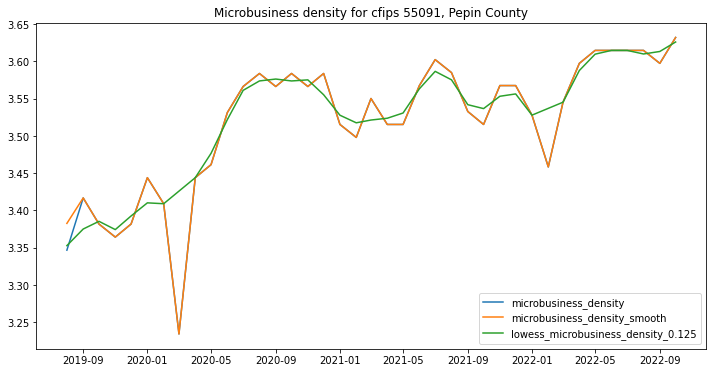

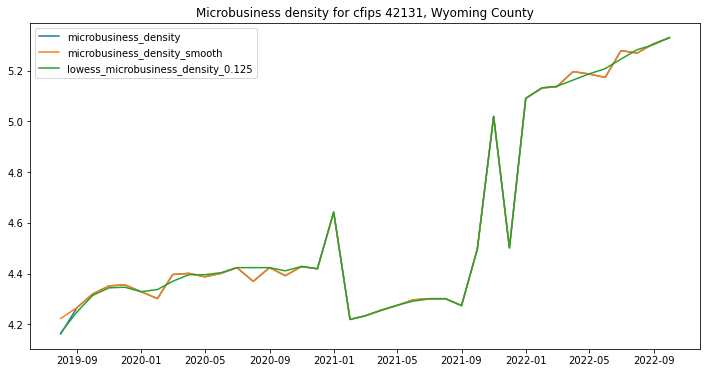

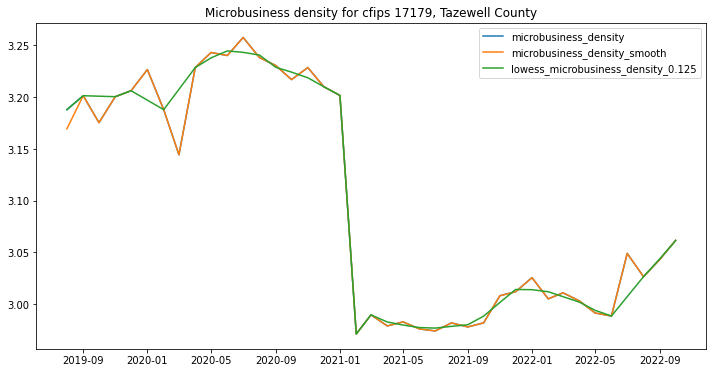

In [12]:
# Plot some microbusiness density

for i in range(3):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    id = np.random.choice(ids)
    temp = df[df["cfips"] == id]
    ax.plot(
        temp["first_day_of_month"],
        temp["microbusiness_density"],
        label="microbusiness_density",
    )
    ax.plot(
        temp["first_day_of_month"],
        temp["microbusiness_density_smooth"],
        label="microbusiness_density_smooth",
    )
    ax.plot(
        temp["first_day_of_month"],
        temp["lowess_microbusiness_density_0.125"],
        label="lowess_microbusiness_density_0.125",
    )
    ax.legend()
    plt.title(f"Microbusiness density for cfips {id}, {temp['county'].values[0]}")
    plt.show()

#### Below a specifc example that shows the smootheness on the jump

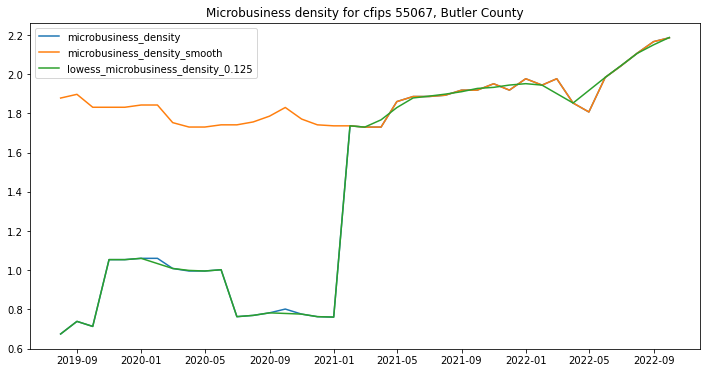

In [13]:
# Plot some microbusiness density


fig, ax = plt.subplots(1, 1, figsize=(12, 6))
id = np.random.choice(ids)
temp = df[df["cfips"] == 1013]
ax.plot(
    temp["first_day_of_month"],
    temp["microbusiness_density"],
    label="microbusiness_density",
)
ax.plot(
    temp["first_day_of_month"],
    temp["microbusiness_density_smooth"],
    label="microbusiness_density_smooth",
)
ax.plot(
    temp["first_day_of_month"],
    temp["lowess_microbusiness_density_0.125"],
    label="lowess_microbusiness_density_0.125",
)
ax.legend()
plt.title(f"Microbusiness density for cfips {id}, {temp['county'].values[0]}")
plt.show()

In [14]:
df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,STNAME,CTYNAME,POPESTIMATE2020,...,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021,microbusiness_density_smooth
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.01,1249,Alabama,Autauga County,58877,...,1.10,0.70,0.60,1.10,55317,58786.00,58731,57982.00,62660.00,2.86
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.88,1198,Alabama,Autauga County,58877,...,1.10,0.70,0.60,1.10,55317,58786.00,58731,57982.00,62660.00,2.88
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.06,1269,Alabama,Autauga County,58877,...,1.10,0.70,0.60,1.10,55317,58786.00,58731,57982.00,62660.00,3.06
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.99,1243,Alabama,Autauga County,58877,...,1.10,0.70,0.60,1.10,55317,58786.00,58731,57982.00,62660.00,2.99
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.99,1243,Alabama,Autauga County,58877,...,1.10,0.70,0.60,1.10,55317,58786.00,58731,57982.00,62660.00,2.99


In [15]:
df.max()

row_id                                    9015_2022-10-01
cfips                                               56045
county                                     Ziebach County
state                                             Wyoming
first_day_of_month                    2022-10-01 00:00:00
microbusiness_density                              284.34
active                                            1167744
STNAME                                            Wyoming
CTYNAME                                    Ziebach County
POPESTIMATE2020                                   9989165
POPESTIMATE2021                                   9829544
year                                                 2022
population                                        7866810
quarter                                                 4
pop_group_2020                                      small
pop_group_2022                                      small
lowess_microbusiness_density_0.125                 284.34
pct_bb_2017   

### Create the timeseries

In [16]:
# Create an empty list to store the new time series
time_series = []

# Loop over each cfips
for cfips in df["cfips"].unique():
    # Filter the data for the current cfips
    df_cfips = df[df["cfips"] == cfips].reset_index(drop=True)
    # Loop over the time series from 0 to 14 (inclusive)
    for i in range(0, 15):
        # Create a new time series with the values for the current cfips and range of first_day_of_month
        time_series.append(
            {
                "cfips": cfips,
                "population": df_cfips.loc[i + 23, "population"],
                "active": df_cfips.loc[i + 23, "active"],
                "microbusiness_density": df_cfips.loc[
                    i : i + 23, "microbusiness_density"
                ].values.tolist(),
                "lowess_microbusiness_density_0.125": df_cfips.loc[
                    i : i + 23, "lowess_microbusiness_density_0.125"
                ].values.tolist(),
                "microbusiness_density_smooth": df_cfips.loc[
                    i : i + 23, "microbusiness_density_smooth"
                ].values.tolist(),
                # as target we are using the original microbusiness density
                "target": df_cfips.loc[i + 24, "microbusiness_density"],
                "target_date": df_cfips.loc[i + 24, "first_day_of_month"],
            }
        )

In [17]:
# Create a new dataframe with the list of time series
new_df = pd.DataFrame(time_series)

In [18]:
# merge with census data
new_df = new_df.merge(census, on="cfips", how="left")
new_df.head()

,cfips,population,active,microbusiness_density,lowess_microbusiness_density_0.125,microbusiness_density_smooth,target,target_date,pct_bb_2017,pct_bb_2018,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,1001,42174,1354,"[3.0076818, 2.8848701, 3.0558431, 2.9932332, 2...","[3.0076818000000265, 3.0321572147540987, 3.055...","[2.8560213990000003, 2.8848701, 3.0558431, 2.9...",3.22,2021-08-01,76.60,78.90,...,1.30,1.10,0.70,0.60,1.10,55317,58786.00,58731,57982.00,62660.00
1,1001,42174,1358,"[2.8848701, 3.0558431, 2.9932332, 2.9932332, 2...","[3.0321572147540987, 3.055843099999644, 3.0122...","[2.8848701, 3.0558431, 2.9932332, 2.9932332, 2...",3.19,2021-09-01,76.60,78.90,...,1.30,1.10,0.70,0.60,1.10,55317,58786.00,58731,57982.00,62660.00
2,1001,42174,1344,"[3.0558431, 2.9932332, 2.9932332, 2.96909, 2.9...","[3.055843099999644, 3.0122545210848077, 2.9867...","[3.0558431, 2.9932332, 2.9932332, 2.96909, 2.9...",3.20,2021-10-01,76.60,78.90,...,1.30,1.10,0.70,0.60,1.10,55317,58786.00,58731,57982.00,62660.00
3,1001,42175,1351,"[2.9932332, 2.9932332, 2.96909, 2.9093256, 2.9...","[3.0122545210848077, 2.9867384385390388, 2.960...","[2.9932332, 2.9932332, 2.96909, 2.9093256, 2.9...",3.20,2021-11-01,76.60,78.90,...,1.30,1.10,0.70,0.60,1.10,55317,58786.00,58731,57982.00,62660.00
4,1001,42174,1350,"[2.9932332, 2.96909, 2.9093256, 2.9332314, 3.0...","[2.9867384385390388, 2.9600524299638176, 2.936...","[2.9932332, 2.96909, 2.9093256, 2.9332314, 3.0...",3.29,2021-12-01,76.60,78.90,...,1.30,1.10,0.70,0.60,1.10,55317,58786.00,58731,57982.00,62660.00


In [19]:
# convert the list of microbusiness_density to a numpy array and then each into a column
new_df["microbusiness_density_smooth"] = new_df["microbusiness_density_smooth"].apply(
    lambda x: np.array(x)
)

new_df = pd.concat(
    [
        new_df.drop(["microbusiness_density_smooth"], axis=1),
        new_df["microbusiness_density_smooth"].apply(pd.Series),
    ],
    axis=1,
)

## Create training datasets

In [20]:
# create X, which is df_new without the target column
X = new_df.drop(
    [
        "target",
        "target_date",
        "cfips",
        "population",
        "active",
        "microbusiness_density",
        "lowess_microbusiness_density_0.125",
    ],
    axis=1,
)
y = new_df["target"]
grps = new_df["cfips"]

In [21]:
# max value per column
X.max()

pct_bb_2017                 94.60
pct_bb_2018                 95.50
pct_bb_2019                 96.00
pct_bb_2020                 97.10
pct_bb_2021                 97.60
pct_college_2017            43.70
pct_college_2018            48.00
pct_college_2019            45.40
pct_college_2020            43.00
pct_college_2021            43.70
pct_foreign_born_2017       52.90
pct_foreign_born_2018       53.30
pct_foreign_born_2019       53.70
pct_foreign_born_2020       54.00
pct_foreign_born_2021       54.00
pct_it_workers_2017         17.40
pct_it_workers_2018         11.70
pct_it_workers_2019         10.50
pct_it_workers_2020         15.20
pct_it_workers_2021         15.20
median_hh_inc_2017      129588.00
median_hh_inc_2018      136268.00
median_hh_inc_2019      142299.00
median_hh_inc_2020      147111.00
median_hh_inc_2021      156821.00
0                          108.40
1                          108.40
2                           95.85
3                           95.85
4             

In [22]:
# use the last target date as the validate date
val_date = new_df["target_date"].max()
y_val = y[new_df["target_date"] == val_date]
X_val = X[new_df["target_date"] == val_date]
y_train = y[new_df["target_date"] != val_date]
X_train = X[new_df["target_date"] != val_date]
y_test = df[df["first_day_of_month"] == df["first_day_of_month"].max()][
    "microbusiness_density"
]

In [23]:
# Shapes of the train and test sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (43890, 49)
y_train shape: (43890,)
X_test shape: (3135, 49)
y_val shape: (3135,)
y_test shape: (3135,)


In [31]:
# Forward fill na values
X_train = X_train.fillna(method="ffill")
X_val = X_val.fillna(method="ffill")

### Select some regressors

In [32]:
regressor_list = [
    ("Linear Regression", LinearRegression()),
    ("Random Forest", RandomForestRegressor()),
    ("XGBoost", XGBRegressor()),
    ("LightGBM", LGBMRegressor()),
    ("CatBoost", CatBoostRegressor(verbose=0)),
    ("Linear SVR", LinearSVR()),
]

In [34]:
# Define some eval metrics
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)


def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))


def r2(y_true, y_pred):
    return 1 - mse(y_true, y_pred) / np.var(y_true)


def smape(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

In [43]:
# Predict on the val set and show the results table like
def predict_and_show_results(regressor, X_train, y_train, X_val, y_val):
    # Fit the regressor
    start = time.time()
    regressor.fit(X_train, y_train)
    end = time.time()
    print(f"{regressor.__class__.__name__} fitted in {end - start:.2f}seconds.")
    # Predict on the test set
    y_pred = regressor.predict(X_val)
    # Create a dataframe with the results
    results = pd.DataFrame(
        {
            "model": regressor.__class__.__name__,
            "train_mse": [mse(y_train, regressor.predict(X_train))],
            "train_rmse": [rmse(y_train, regressor.predict(X_train))],
            "train_r2": [r2(y_train, regressor.predict(X_train))],
            "train_smape": [smape(y_train, regressor.predict(X_train))],
            "val_mse": [mse(y_val, y_pred)],
            "val_rmse": [rmse(y_val, y_pred)],
            "val_r2": [r2(y_val, y_pred)],
            "val_smape": [smape(y_val, y_pred)],
            "time": [end - start],
        }
    )
    # Show the results
    # display(results)
    # Plot the results
    # plt.figure(figsize=(12, 6))
    # plt.plot(y_val, label="actual")
    # plt.plot(y_pred, label="predicted")
    # plt.title(f"{regressor.__class__.__name__} results")
    # plt.legend()
    # plt.show()
    return results


In [45]:
results = pd.concat(
    [
        predict_and_show_results(regressor[1], X_train, y_train, X_val, y_val)
        for regressor in tqdm(regressor_list, desc="Fitting models", leave=False)
    ]
)

Fitting models:   0%|          | 0/6 [00:00<?, ?it/s]

LinearRegression fitted in 0.12seconds.
RandomForestRegressor fitted in 206.29seconds.
XGBRegressor fitted in 5.74seconds.
LGBMRegressor fitted in 0.47seconds.
CatBoostRegressor fitted in 10.43seconds.
LinearSVR fitted in 15.33seconds.


In [46]:
results

,model,train_mse,train_rmse,train_r2,train_smape,val_mse,val_rmse,val_r2,val_smape,time
0,LinearRegression,9.54,3.09,0.71,0.04,3.22,1.79,0.92,0.03,0.12
0,RandomForestRegressor,0.60,0.78,0.98,0.00,4.06,2.02,0.89,0.01,206.29
0,XGBRegressor,0.01,0.09,1.00,0.01,4.20,2.05,0.89,0.01,5.74
0,LGBMRegressor,0.35,0.60,0.99,0.01,8.31,2.88,0.78,0.01,0.47
0,CatBoostRegressor,0.10,0.31,1.00,0.01,5.17,2.27,0.86,0.01,10.43
0,LinearSVR,12.22,3.50,0.63,0.13,8.89,2.98,0.77,0.12,15.33


In [ ]:
#plot the validation and the training
plt.figure(figsize=(12, 6))
plt.plot(y_val, label="actual")
plt.plot(y_train, label="train")


In [85]:
model = XGBRegressor(
    objective="reg:pseudohubererror",
    # objective='reg:squarederror',
    tree_method="hist",
    n_estimators=4999,
    learning_rate=0.0075,
    max_leaves=17,
    subsample=0.50,
    colsample_bytree=0.50,
    max_bin=4096,
    n_jobs=2,
    eval_metric="mae",
)
model.fit(X.values, y.values)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0075, max_bin=4096,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=17,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=4999, n_jobs=2, num_parallel_tree=None,
             objective='reg:pseudohubererror', predictor=None, ...)

In [87]:
# get the latest data
latest_data = new_df[new_df["target_date"] == new_df["target_date"].max()].drop(
    [
        "target_date",
        "population",
        "active",
        "microbusiness_density",
        "lowess_microbusiness_density_0.125",
    ],
    axis=1,
)
latest_data[24] = latest_data["target"]

In [88]:
cols1 = [
    "pct_bb_2017",
    "pct_bb_2018",
    "pct_bb_2019",
    "pct_bb_2020",
    "pct_bb_2021",
    "pct_college_2017",
    "pct_college_2018",
    "pct_college_2019",
    "pct_college_2020",
    "pct_college_2021",
    "pct_foreign_born_2017",
    "pct_foreign_born_2018",
    "pct_foreign_born_2019",
    "pct_foreign_born_2020",
    "pct_foreign_born_2021",
    "pct_it_workers_2017",
    "pct_it_workers_2018",
    "pct_it_workers_2019",
    "pct_it_workers_2020",
    "pct_it_workers_2021",
    "median_hh_inc_2017",
    "median_hh_inc_2018",
    "median_hh_inc_2019",
    "median_hh_inc_2020",
    "median_hh_inc_2021",
]
# select cols1 and the last 24 columns from the dataframe
cols = cols1 + list(latest_data.columns[-24:])

In [89]:
# Define the number of future instances to predict
n_future = test["first_day_of_month"].unique().shape[0]
# Get the list of unique IDs
ids = test["cfips"].unique()


# get the latest data
latest_data = new_df[new_df["target_date"] == new_df["target_date"].max()].drop(
    [
        "target_date",
        "population",
        "active",
        "microbusiness_density",
        "lowess_microbusiness_density_0.125",
    ],
    axis=1,
)
latest_data[24] = latest_data["target"]

# initialize predictions array
predictions = np.zeros((len(ids), 8))

# loop over each prediction
for i in range(8):
    cols = cols1 + list(latest_data.columns[-24:])
    # use the latest 24 instances for each prediction
    prediction_data = latest_data.loc[:, cols]
    prediction = model.predict(prediction_data)
    predictions[:, i] = prediction

    # use the last prediction as input for the next prediction
    latest_data[25 + i] = predictions[:, i]

# print the predictions
print(predictions)

[[3.46878052 3.49344063 3.50045967 ... 3.53506947 3.53541017 3.5536654 ]
 [8.4449091  8.47481251 8.47890759 ... 8.52009964 8.54811478 8.60557175]
 [1.21318734 1.21599853 1.21378517 ... 1.22191119 1.2226944  1.22262347]
 ...
 [4.01612902 4.01016521 4.01076317 ... 4.0116663  4.01025772 4.01070452]
 [3.19418287 3.15348244 3.2153399  ... 3.17633367 3.22008562 3.17633367]
 [1.80352354 1.81204605 1.82432342 ... 1.83882046 1.83890128 1.83882046]]


In [90]:
test.sort_values(by=["cfips", "first_day_of_month"], inplace=True)

In [91]:
test["microbusiness_density"] = predictions.reshape(-1)

### Reflection from the below plot:
Clearly the smoothing is having a negative effect in the first prediction, as it becomes missaligned in some instances, we should explore creating some threshold.

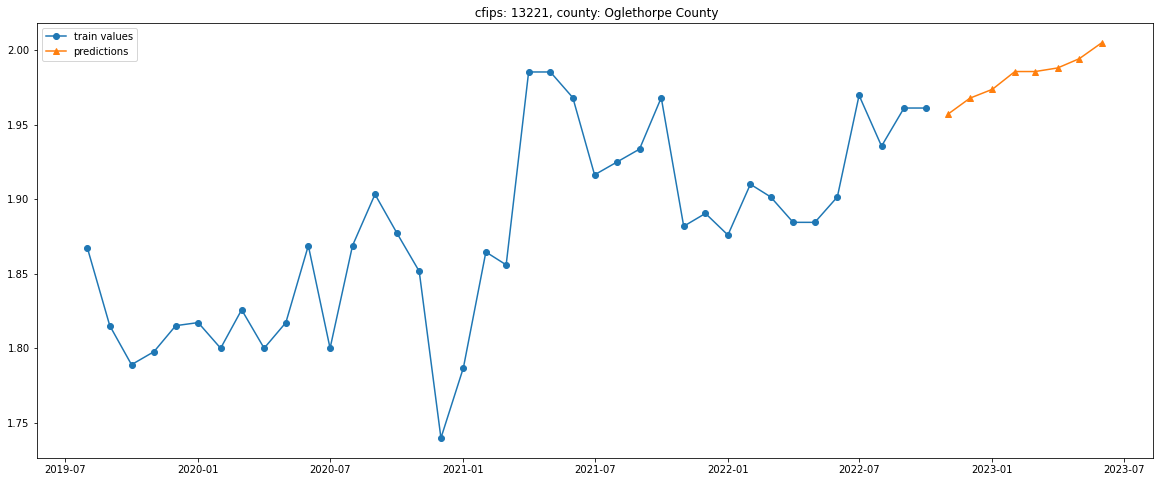

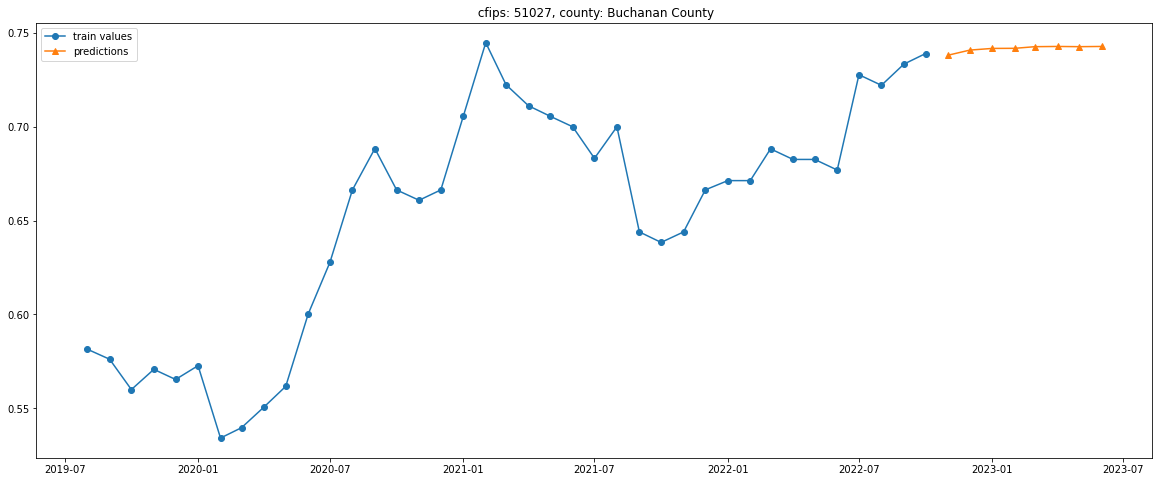

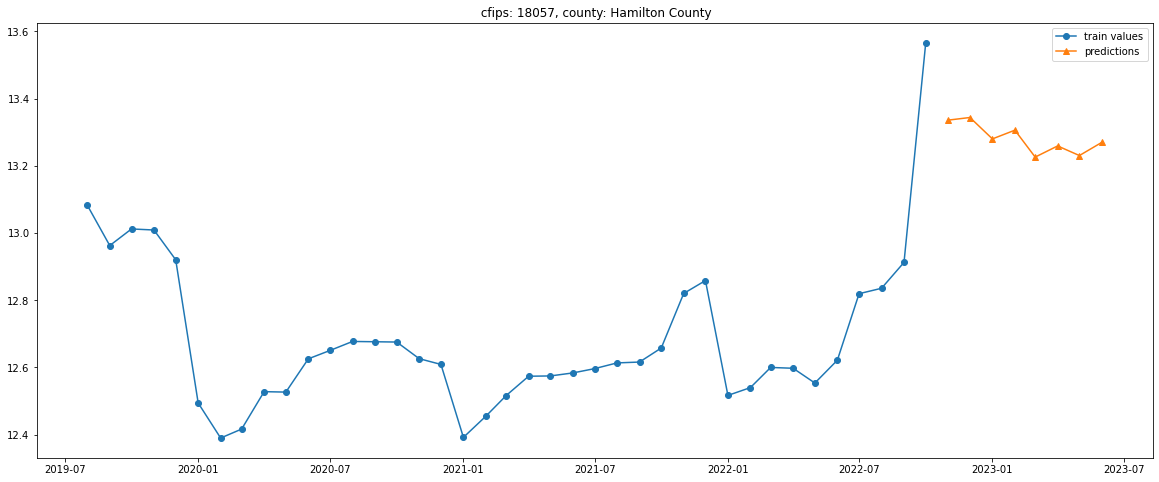

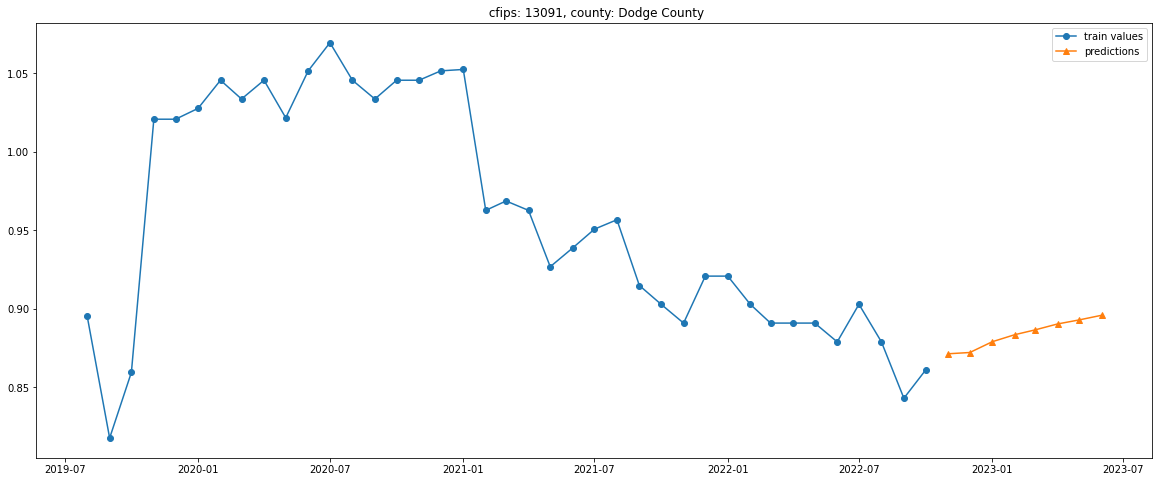

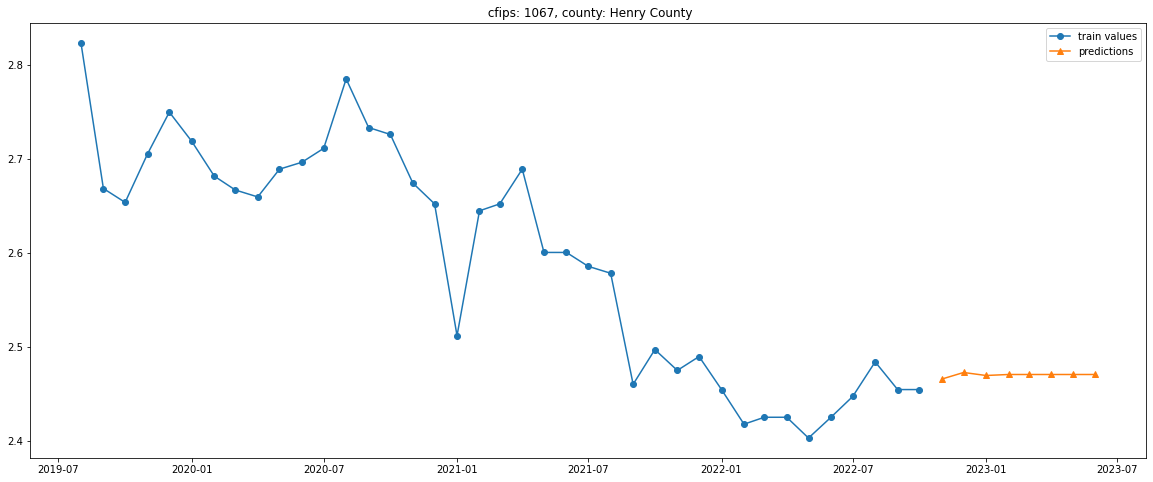

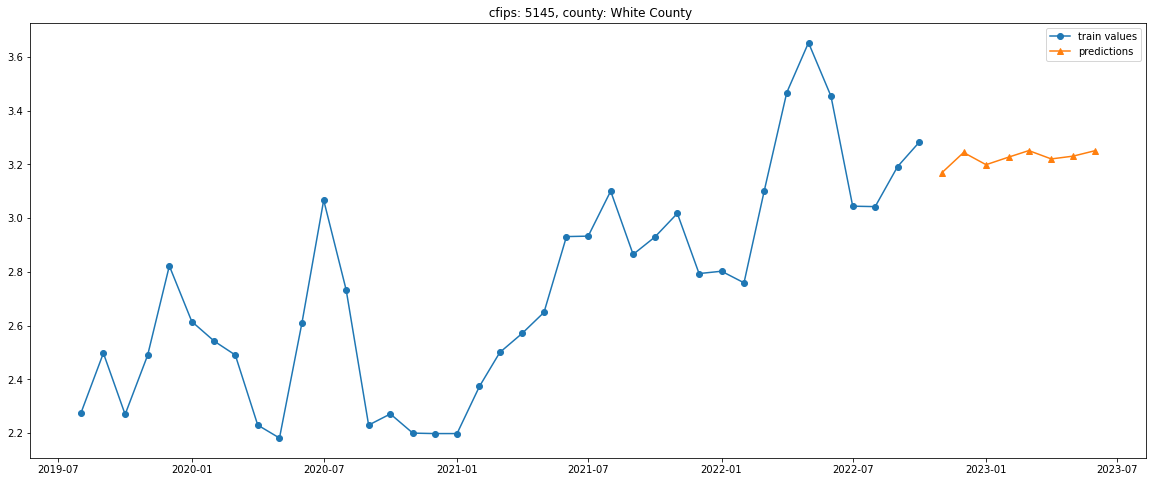

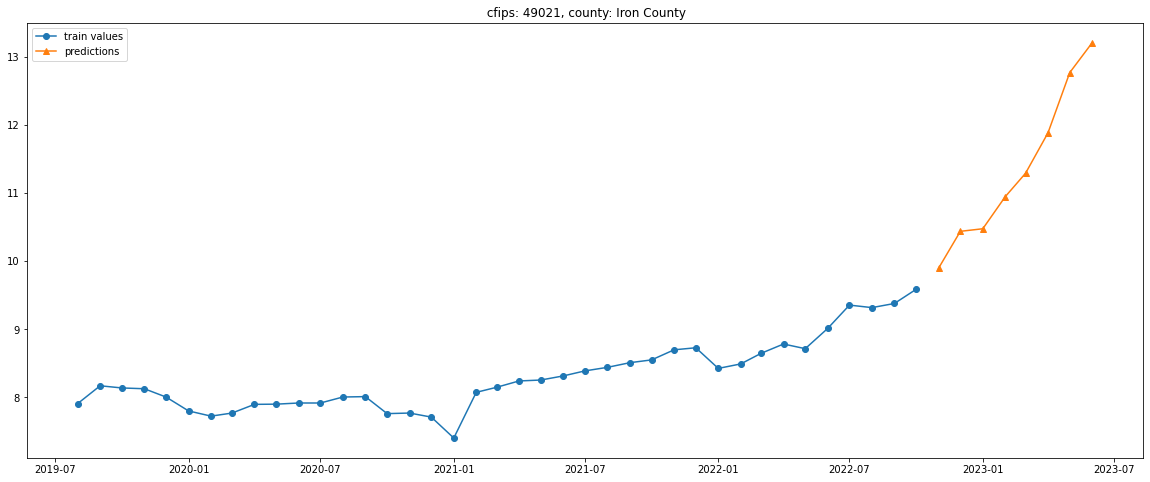

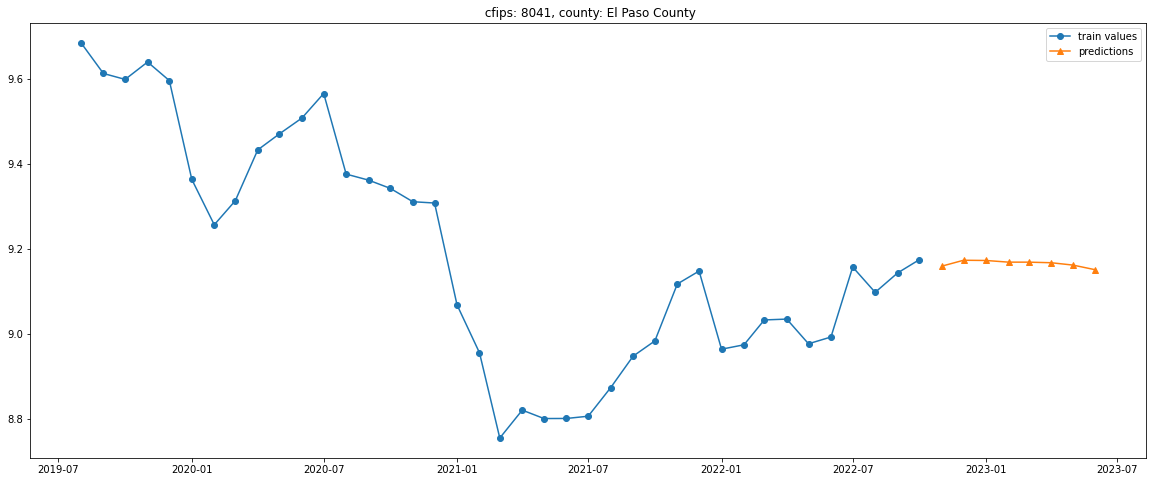

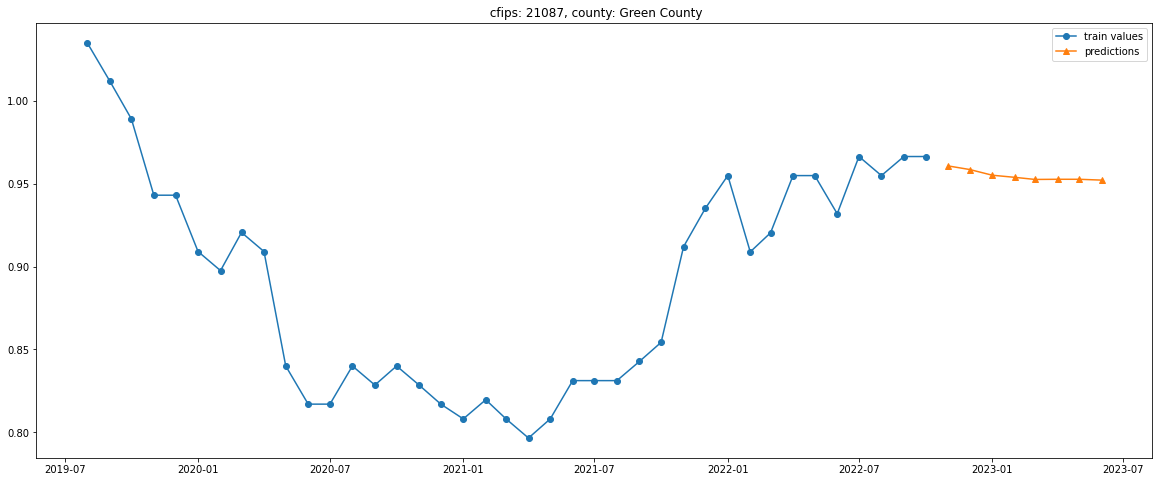

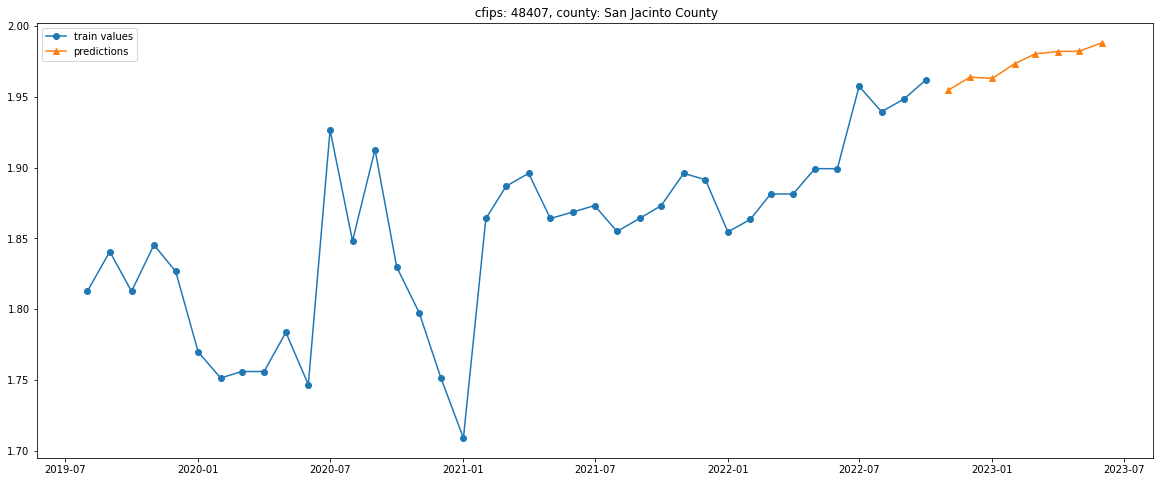

In [92]:
for i in range(10):
    c = np.random.choice(ids)
    plot_df = df[df["cfips"] == c].copy()
    test_plot = test[test["cfips"] == c].copy()
    plot_df["first_day_of_month"] = pd.to_datetime(plot_df["first_day_of_month"])
    test_plot["first_day_of_month"] = pd.to_datetime(test_plot["first_day_of_month"])
    last_target = plot_df["microbusiness_density"].values[-1]

    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    plt.plot(
        plot_df["first_day_of_month"],
        plot_df["microbusiness_density"],
        "-o",
        label="train values",
    )
    plt.plot(
        test_plot["first_day_of_month"],
        test_plot["microbusiness_density"],
        "-^",
        label="predictions",
    )
    plt.title(f" cfips: {c}, county: {plot_df['county'].values[0]}")
    plt.legend()
    plt.show()

### Persist

In [94]:
result = test[["row_id", "microbusiness_density"]]
result.to_csv("../data/submissions/ml_all_features.csv", index=False)